## Import related API

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential, layers, backend, optimizers
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, LeakyReLU, GRU, BatchNormalization
from keras.layers.core import RepeatVector
from keras.callbacks import EarlyStopping

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline

## Read file

In [ ]:
def read(path):
    return pd.read_csv(path)

In [ ]:
path = "WeeklyFinalData.csv"
finalData = read(path)

In [ ]:
train = finalData

In [ ]:
date = train["Date"]
train.drop("Date",axis=1,inplace=True)

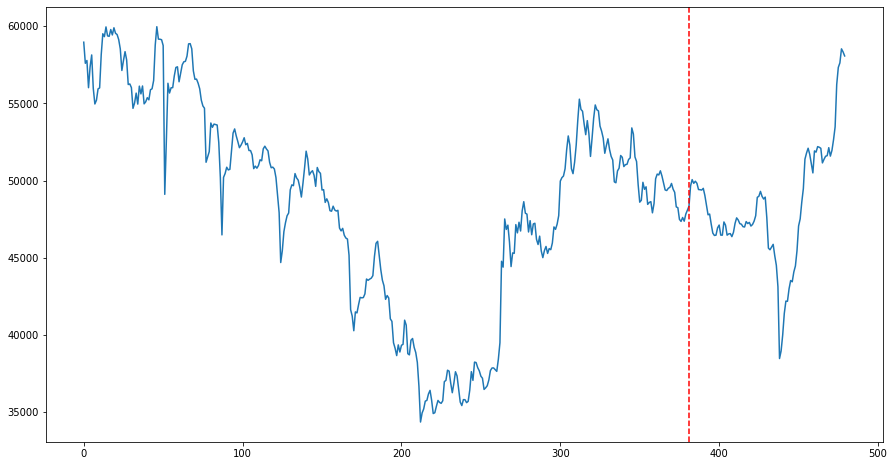

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(train["CCSP"])
plt.axvline(x=381, color='r', linestyle='--')

plt.savefig('CCSP.png')

## Visualization for raw data

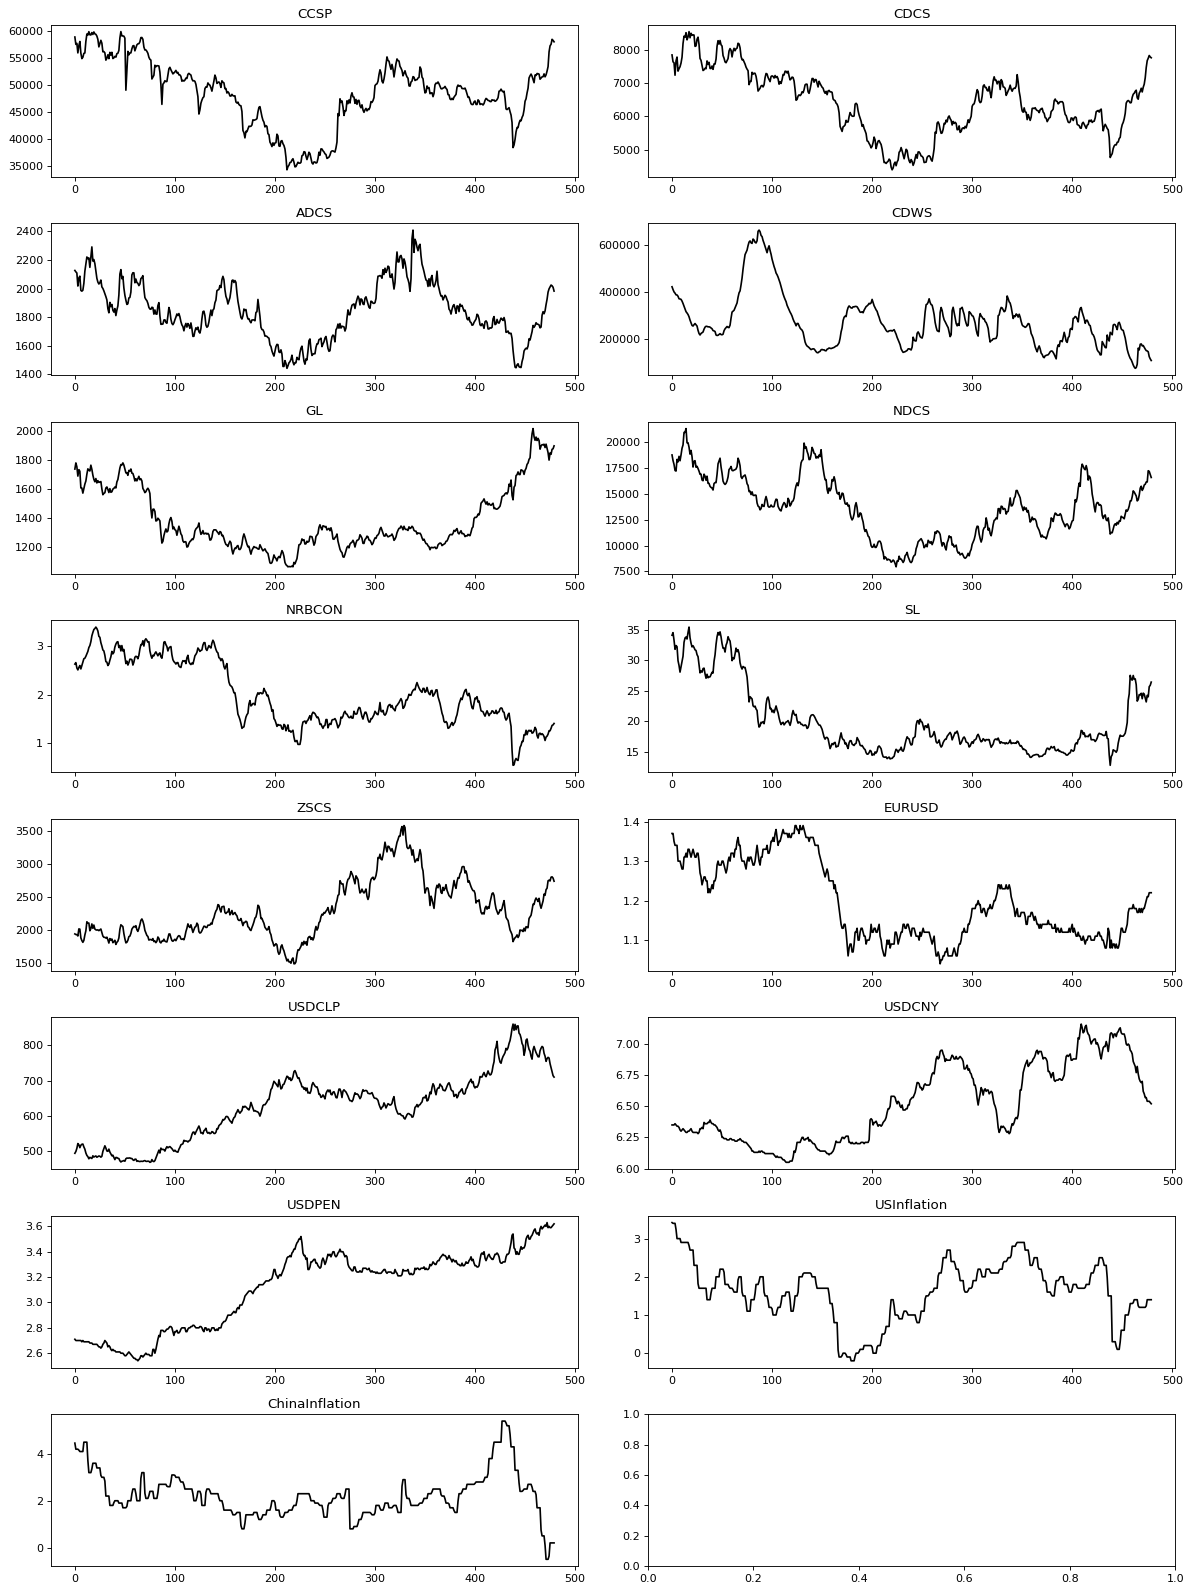

In [ ]:
def show_raw_visualization(data):

    fig, axes = plt.subplots(
        nrows=int(round(data.shape[1]/2,0)), ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )

    for i in range(data.shape[1]):
        t_data = data.iloc[:,i]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color="black",
            title=data.columns[i]
        )
        
        
    plt.tight_layout()
    plt.savefig('raw_data.png')


show_raw_visualization(train)

## Data preprocessing

### Add lag time as a predicted factor 
1. Add lag time from 1 to 4 for CCSP (Yangtze River nonferrous metals, China)
2. Split the data to Training set & Test set

In [ ]:
def buildTrain(train, pastWeek=1, futureWeek=4, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
        X = np.array(train.iloc[i:i+defaultWeek])
        X = np.append(X,train["CCSP"].iloc[i+defaultWeek:i+pastWeek])
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    return np.array(X_train), np.array(Y_train)

### Min-max scaling 
the data is scaled to a fixed range [0,1]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

### Setting the format of the learning graph

In [ ]:
def show_raw_visualization(data, lag_time):

    fig, axes = plt.subplots(
        nrows=int(round(data.shape[1]/2,0)), ncols=2, figsize=(15, 5), dpi=80, facecolor="w", edgecolor="k"
    )

    for i in range(data.shape[1]):
        t_data = data.iloc[:,i]
        ax = t_data.plot(
            ax=axes[i % 2],
            color="black",
            title="Lag:{0}, {1} curve".format(lag_time+1, data.columns[i])
        )
    
#     fig.set_size_inches(10,15)
        
    plt.tight_layout()

## Building Model

### 2-layer Neural Network

In [ ]:
def buildTwoLayerNN(training_data_shape, designated_units):

    keras.backend.clear_session()
    regressor = Sequential()
    regressor.add(Dense(units=designated_units, activation ="relu", input_dim=training_data_shape, kernel_initializer = "uniform"))
    regressor.add(Dense(units=1)) 

    adam = optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999, decay=1e-6)



    regressor.compile(optimizer=adam, loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError()])
    regressor.summary()

    return regressor

In [ ]:
from sklearn.metrics import mean_squared_error

Lag time = 1
---Normalize---
---Check the data dimension---
X1_training_scaled:(382, 15)
Y1_training_scaled:(382, 1)
X1_test_scaled:(96, 15)
Y1_test_scaled:(96, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 511
Trainable params: 511
Non-trainable params: 0
_________________________________________________________________
[Info] RMSE of training data = 0.039
[Info] RMSE of testing data = 0.110

Lag time = 2
---Normalize---
---Check the data dimension---
X1_training_scaled:(381, 16)
Y1_training_scaled:(381, 1)
X1_test_scaled:(96, 16)
Y1_test_scaled:(96, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Out

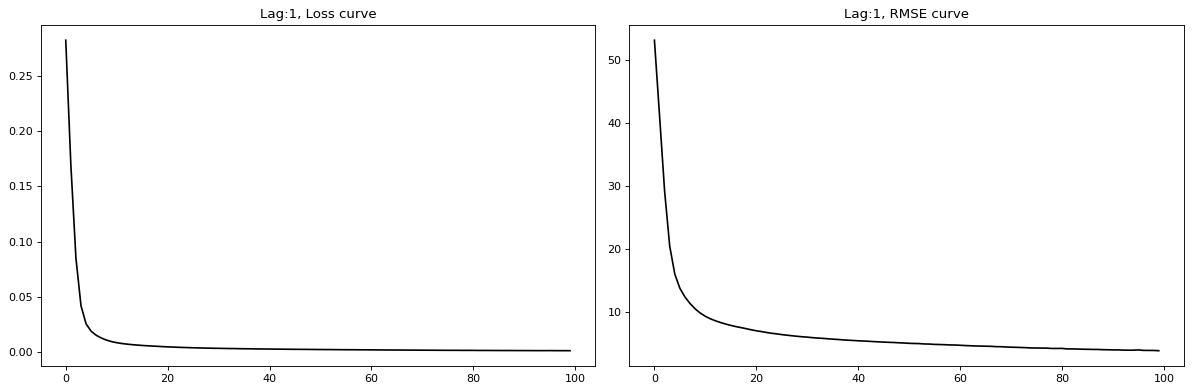

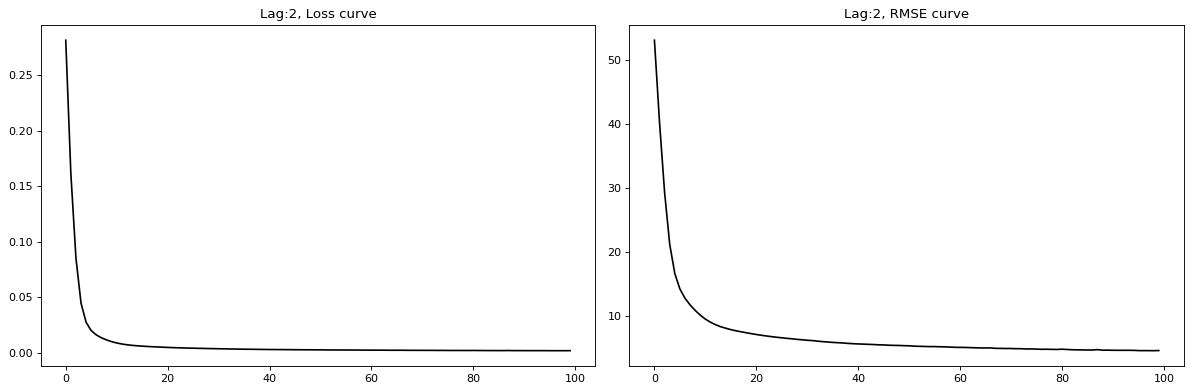

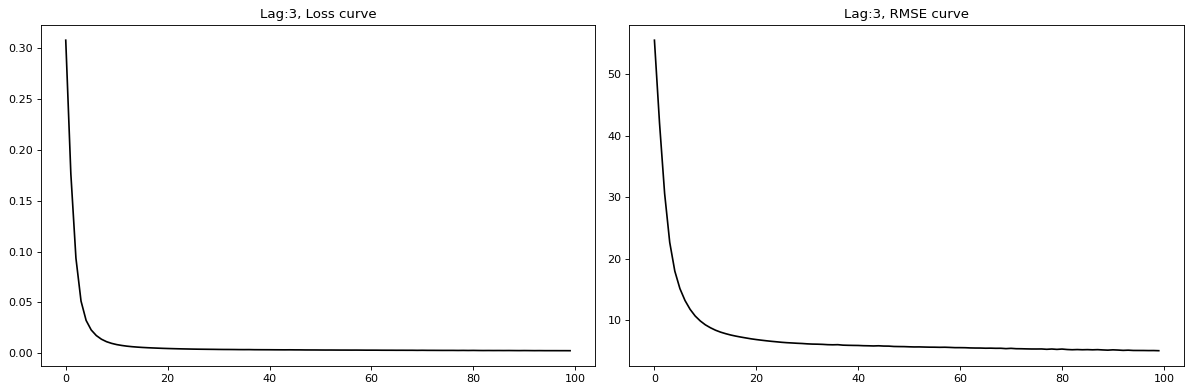

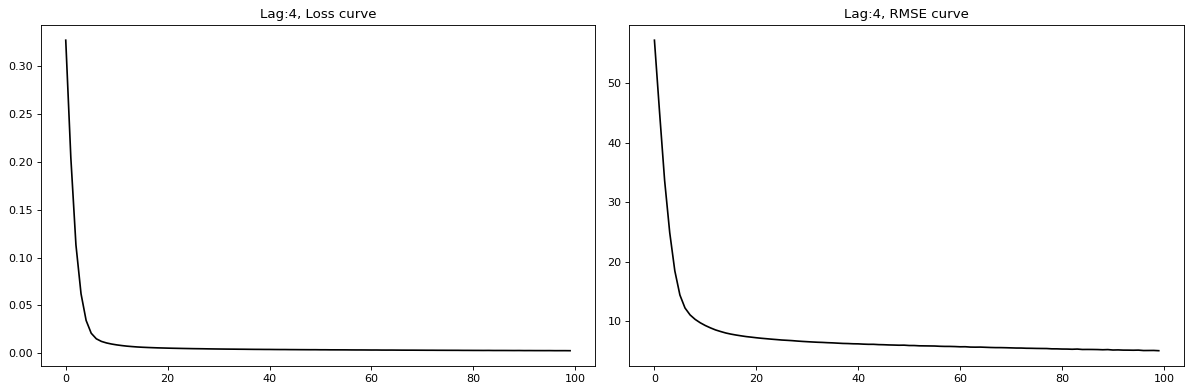

In [ ]:
## Using different time lag
for i in range(4):

    print("Lag time = {}".format(i+1))
    ## Time lag
    X1_train, Y1_train= buildTrain(train, pastWeek=i+1, futureWeek=1)

    ## Split date to training & test data
    X1_training = pd.DataFrame(X1_train[0:int(X1_train.shape[0]*0.8)])
    X1_test = pd.DataFrame(X1_train[int(X1_train.shape[0]*0.8):])

    Y1_training = pd.DataFrame(Y1_train[0:int(Y1_train.shape[0]*0.8)])
    Y1_test = pd.DataFrame(Y1_train[int(Y1_train.shape[0]*0.8):])

    ## Normalize
    print("---Normalize---")
    X1_training_scaled = sc.fit_transform(X1_training)
    X1_test_scaled = sc.transform(X1_test)

    Y1_training_scaled = sc.fit_transform(Y1_training)
    Y1_test_scaled = sc.transform(Y1_test)

    ## Check the data dimension
    print("---Check the data dimension---")
    print("X1_training_scaled:{0}".format(X1_training_scaled.shape))
    print("Y1_training_scaled:{0}".format(Y1_training_scaled.shape))
    print("X1_test_scaled:{0}".format(X1_test_scaled.shape))
    print("Y1_test_scaled:{0}".format(Y1_test_scaled.shape))


    ## Training model
    input_sahpe = X1_training_scaled.shape[1]
    regressor = buildTwoLayerNN(input_sahpe, 30)
    history = regressor.fit(X1_training_scaled, Y1_training_scaled, epochs=100, batch_size=8, verbose=0)

    ## Draw the learning graph
    RMSE = [i*100.0 for i in history.history["root_mean_squared_error"]]
    data = pd.DataFrame({"Loss":history.history["loss"], "RMSE":RMSE})
    show_raw_visualization(data, i)

    ## Evaluate the model using testing data
    training_pre = regressor.predict(X1_training_scaled) 
#     training_pre = sc.inverse_transform(pd.DataFrame(training_pre))
    training_error = np.sqrt(mean_squared_error(training_pre, Y1_training_scaled))
    
    testing_pre = regressor.predict(X1_test_scaled) 
#     testing_pre = sc.inverse_transform(pd.DataFrame(testing_pre))
    testing_error = np.sqrt(mean_squared_error(testing_pre, Y1_test_scaled))
    
    print("[Info] RMSE of training data = {:2.3f}".format(training_error))
    print("[Info] RMSE of testing data = {:2.3f}".format(testing_error))
    print()

### SVR using linear/ polynominal/ RBF kernel

In [ ]:
def predict_prices(X_training, Y_training, X_testing, Y_testing):
    
    svr_lin = SVR(kernel='linear')
    svr_poly = SVR(kernel = 'poly', C=1e3 , degree = 2 )
    svr_rbf = SVR(kernel = 'rbf', C=1e3 , gamma = 0.1)
    svr_lin.fit(X_training, Y_training)    
    svr_poly.fit(X_training, Y_training)
    svr_rbf.fit(X_training, Y_training)
    

    svrs = [svr_lin, svr_poly, svr_rbf]
    kernel_label = ['Linear', 'Polynomial', 'RBF']
    model_color = ['g', 'b', 'r']

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15), sharey=True)
    
    for ix, svr in enumerate(svrs):

#         train_obs = sc.inverse_transform(pd.DataFrame(Y_training))
#         train_pre = sc.inverse_transform(pd.DataFrame(svr.predict(X_training)))

#         test_obs = sc.inverse_transform(pd.DataFrame(Y_testing))
#         test_pre = sc.inverse_transform(pd.DataFrame(svr.predict(X_testing)))

        train_obs = Y_training
        train_pre = svr.predict(X_training)

        test_obs = Y_testing
        test_pre = svr.predict(X_testing)

        axes[0, ix].scatter(range(Y_training.shape[0]), train_obs, color='black', label = 'data')
        axes[0, ix].plot(train_pre, color= model_color[ix], label =kernel_label[ix])
        axes[0, ix].legend()
        axes[0, ix].set_title("Training Step: "+kernel_label[ix]+" kenel")
        axes[0, ix].set_xlabel("Sample index(weekly)")
        axes[0, ix].set_ylabel("Copper price ($/ton)")
        
        axes[1, ix].scatter(range(Y_testing.shape[0]), test_obs, color='black', label = 'data')
        axes[1, ix].plot(test_pre, color= model_color[ix], label =kernel_label[ix])
        axes[1, ix].legend()
        axes[1, ix].set_title("Testing Step: "+kernel_label[ix]+" kenel")
        axes[1, ix].set_xlabel("Sample index(weekly)")
        axes[1, ix].set_ylabel("Copper price ($/ton)")
        
        training_RMSE = np.sqrt(mean_squared_error(train_obs, train_pre))
        testing_RMSE = np.sqrt(mean_squared_error(test_obs, test_pre))

        print("The RMSE of SVR using %s kenel\nTraining step:%.3f\tTest step:%.3f" %(kernel_label[ix], training_RMSE, testing_RMSE))

    fig.suptitle("Support Vector Regression", fontsize=14)
    plt.tight_layout()
    plt.show()

Lag time = 1
---Normalize---
The RMSE of SVR using Linear kenel
Training step:0.049	Test step:0.157
The RMSE of SVR using Polynomial kenel
Training step:0.056	Test step:0.336
The RMSE of SVR using RBF kenel
Training step:0.054	Test step:0.163


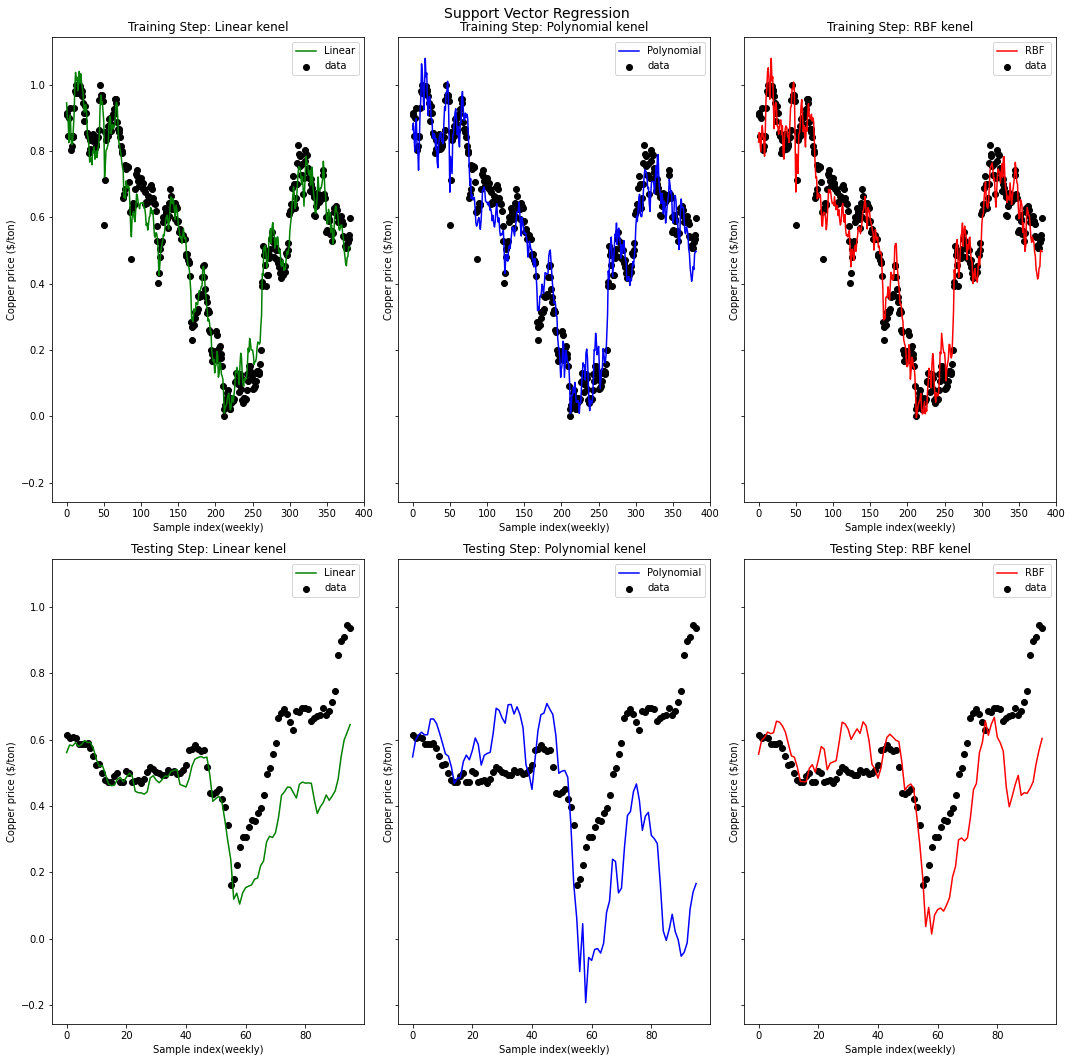

Lag time = 2
---Normalize---
The RMSE of SVR using Linear kenel
Training step:0.052	Test step:0.109
The RMSE of SVR using Polynomial kenel
Training step:0.058	Test step:0.760
The RMSE of SVR using RBF kenel
Training step:0.054	Test step:0.338


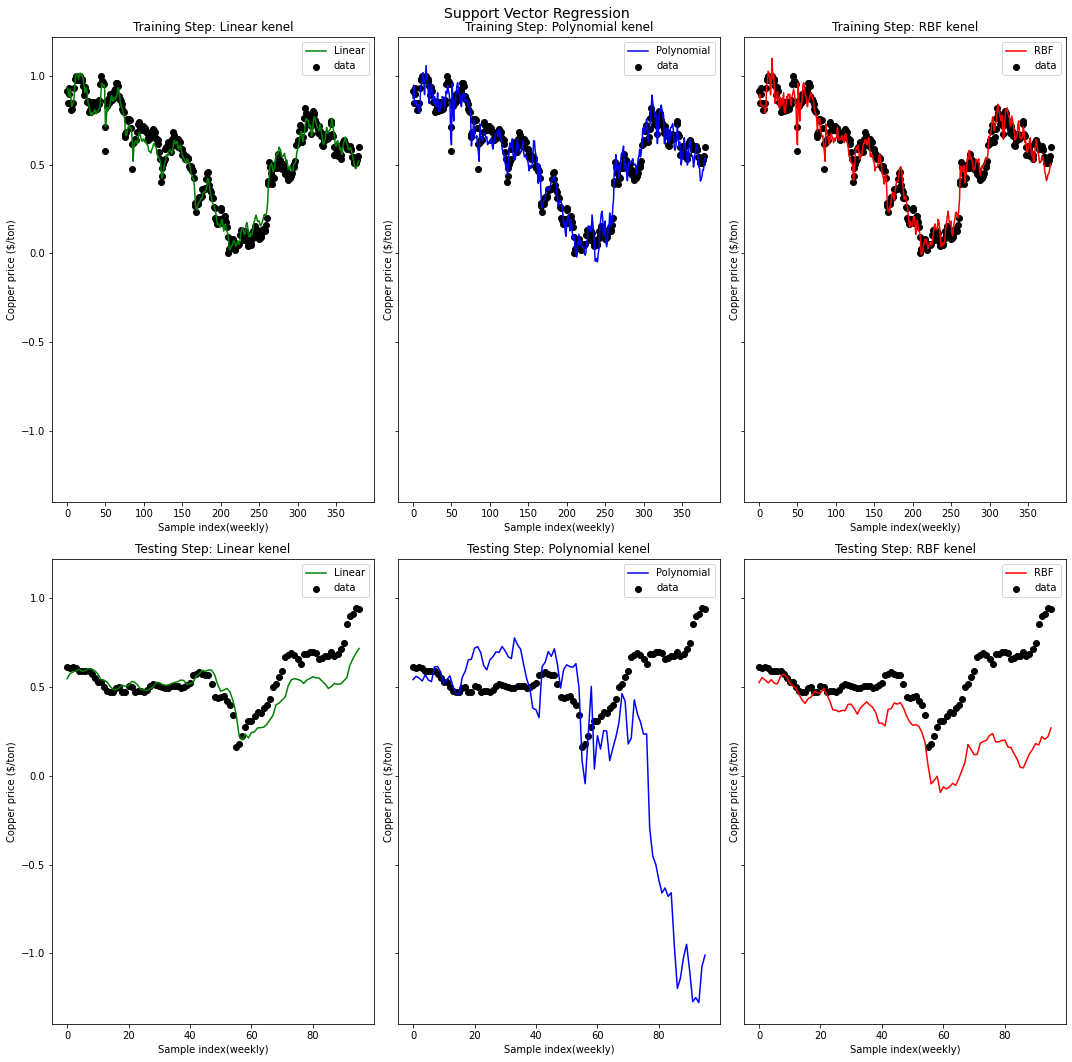

Lag time = 3
---Normalize---
The RMSE of SVR using Linear kenel
Training step:0.054	Test step:0.094
The RMSE of SVR using Polynomial kenel
Training step:0.059	Test step:0.767
The RMSE of SVR using RBF kenel
Training step:0.056	Test step:0.324


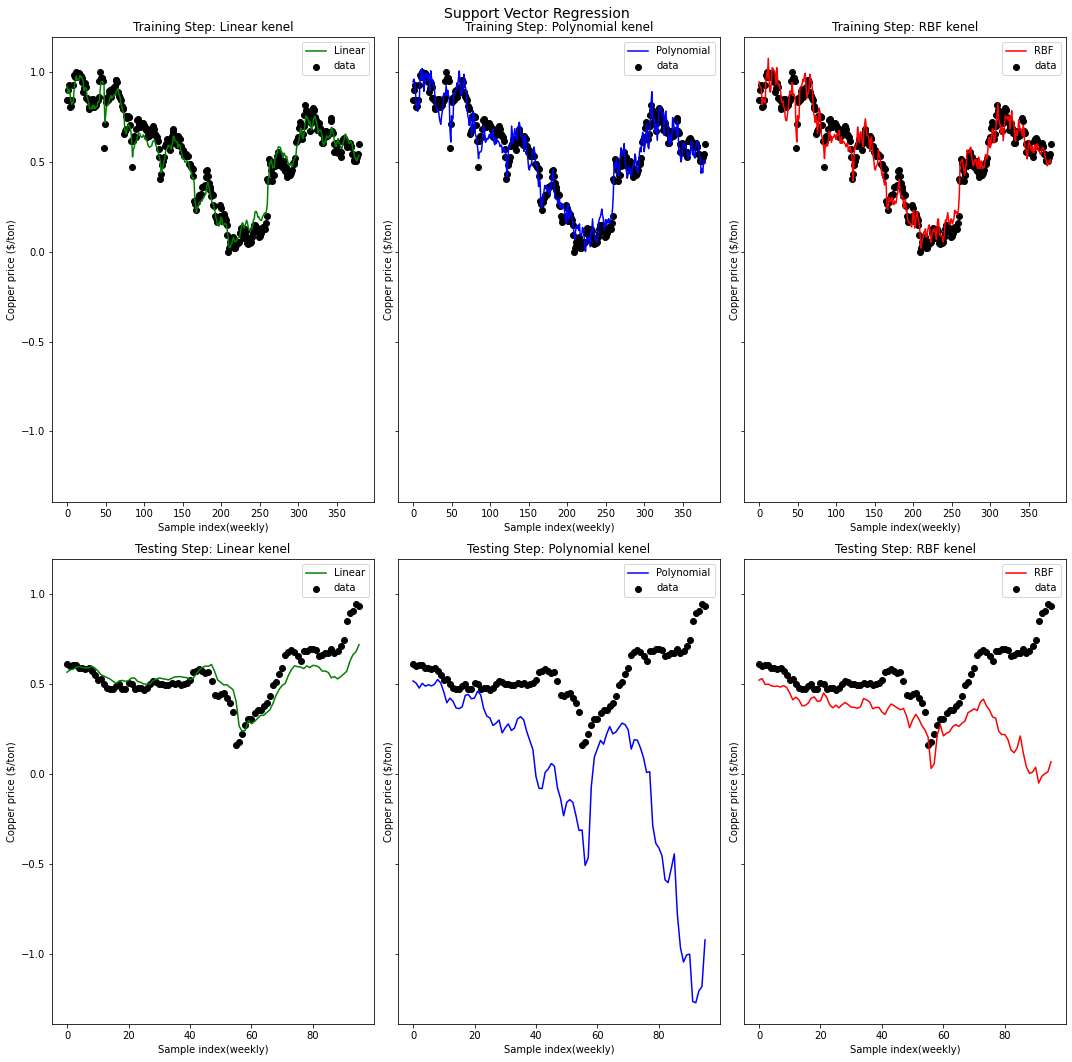

Lag time = 4
---Normalize---
The RMSE of SVR using Linear kenel
Training step:0.053	Test step:0.113
The RMSE of SVR using Polynomial kenel
Training step:0.061	Test step:0.590
The RMSE of SVR using RBF kenel
Training step:0.060	Test step:0.490


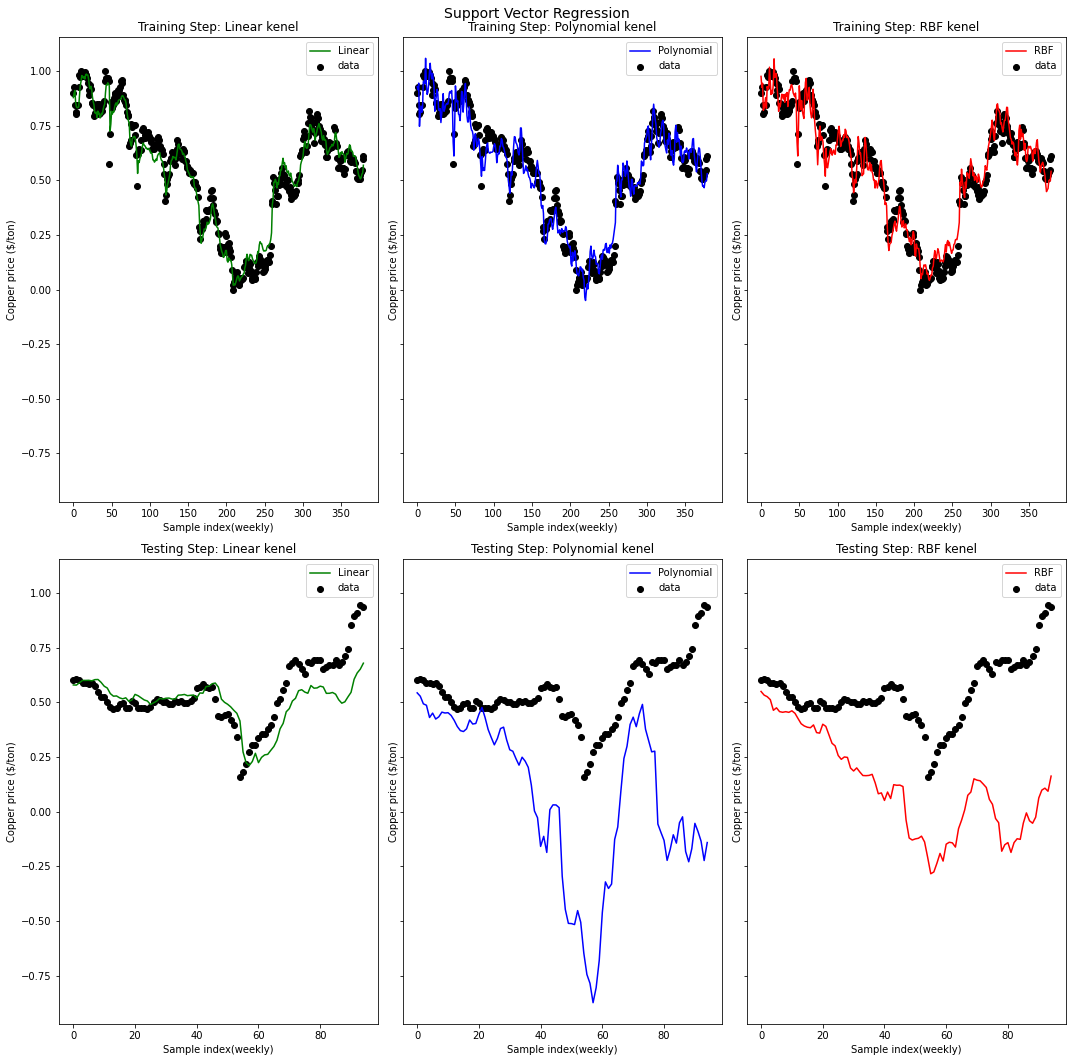

In [ ]:
## Using different time lag
for i in range(4):

    print("Lag time = {}".format(i+1))
    ## Time lag
    X1_train, Y1_train= buildTrain(train, pastWeek=i+1, futureWeek=1)

    ## Split date to training & test data
    X1_training = pd.DataFrame(X1_train[0:int(X1_train.shape[0]*0.8)])
    X1_test = pd.DataFrame(X1_train[int(X1_train.shape[0]*0.8):])

    Y1_training = pd.DataFrame(Y1_train[0:int(Y1_train.shape[0]*0.8)])
    Y1_test = pd.DataFrame(Y1_train[int(Y1_train.shape[0]*0.8):])

    ## Normalize
    print("---Normalize---")
    X1_training_scaled = sc.fit_transform(X1_training)
    X1_test_scaled = sc.transform(X1_test)

    Y1_training_scaled = sc.fit_transform(Y1_training)
    Y1_test_scaled = sc.transform(Y1_test)

    ## Training model
    predict_prices(X1_training_scaled, Y1_training_scaled, X1_test_scaled, Y1_test_scaled)